# HW4

## Question 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

plt.rcParams["figure.figsize"] = (8,6)

In [ ]:
from sklearn.datasets import fetch_openml
mnist_data = fetch_openml(data_id=554)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
def plot_digits_with_predictions(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).item()
          drawColor = 'black'
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)
        im.set_clim(0, 16)

In [ ]:
def plot_digits(data,img_size=28, rows=10):
  fig, ax = plt.subplots(rows, 10, figsize=(8, 8),
                          subplot_kw=dict(xticks=[], yticks=[]))
  fig.subplots_adjust(hspace=0.05, wspace=0.05)
  for i, axi in enumerate(ax.flat):
      if i < data.shape[0]:
        im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
      im.set_clim(0, 16)

In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

In [ ]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)                   # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

In [ ]:
def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

In [ ]:
def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

In [ ]:
def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

In [ ]:
def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [ ]:
def computeLabelAccuracy(model, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      correct += (output>0).eq(target>0).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, numClasses)

    def forward(self, x):
        x = x.view(-1,self.flatSize)  #Pytorch will replace -1 with the batch size
        x = self.linear1(x)
        return x

In [ ]:
def SigmoidLoss(output, target): #L2 Loss - same as nn.MSELoss()
   loss = torch.mean((torch.sigmoid(output) - target)**2)
   return loss

In [ ]:
def MSE(output, target): #L2 Loss - same as nn.MSELoss()
   loss = torch.mean((output - target)**2)
   return loss

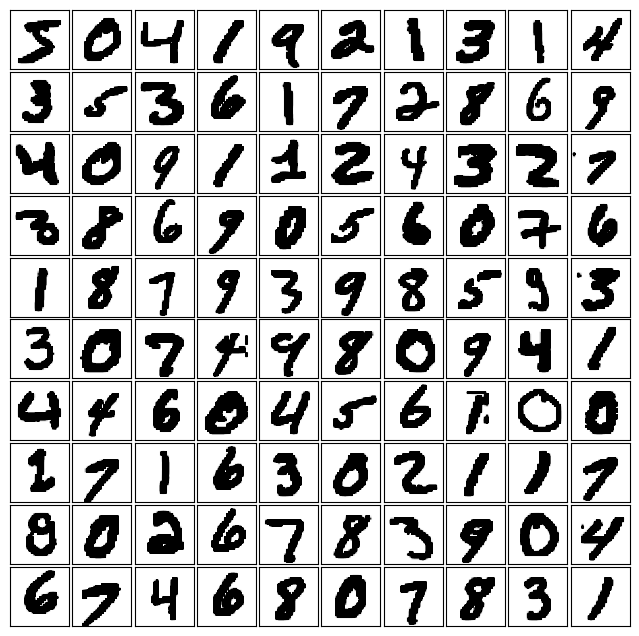

In [ ]:
plot_digits(mnist_data.data.values)

In [ ]:
mnist_data.target[2]

'4'

In [ ]:
mnist_training_data = mnist_data.data.values[0:60000,:]
mnist_training_labels = mnist_data.target.values[0:60000]
mnist_testing_data = mnist_data.data.values[60000:,:]
mnist_testing_labels = mnist_data.target.values[60000:]

In [ ]:
lucky_nums = ['3','7','8']
lucky_training = mnist_training_labels.isin(lucky_nums).astype(int)
lucky_testing = mnist_testing_labels.isin(lucky_nums).astype(int)

In [ ]:
lucky_training = np.expand_dims(lucky_training, 1)
lucky_testing = np.expand_dims(lucky_testing, 1)

In [ ]:
training_dataset = NumpyDataset(mnist_training_data,lucky_training)
testing_dataset = NumpyDataset(mnist_testing_data,lucky_testing)

Loaded Data
Epoch [1/30], Train Loss: 0.1993, Test Loss: 0.1691
Epoch [6/30], Train Loss: 0.1308, Test Loss: 0.1359
Epoch [11/30], Train Loss: 0.1236, Test Loss: 0.1277
Epoch [16/30], Train Loss: 0.1211, Test Loss: 0.1280
Epoch [21/30], Train Loss: 0.1173, Test Loss: 0.1216
Epoch [26/30], Train Loss: 0.1165, Test Loss: 0.1214


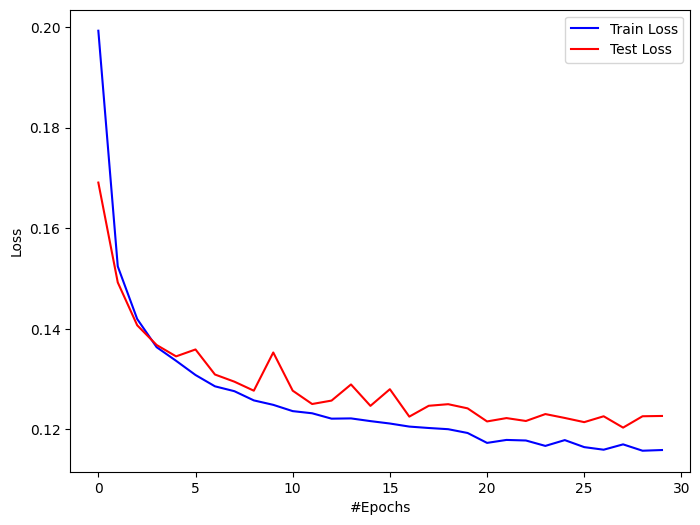

In [ ]:
#Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.0001
batch_size = 100

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = LinearClassifier(image_w, image_h, 1)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = SigmoidLoss

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
computeLabelAccuracy(model, training_generator, "Test Set")
computeLabelAccuracy(model, testing_generator, "Train Set")


Test Set: Accuracy: 52766/60000 (87.9%)

Train Set: Accuracy: 8732/10000 (87.3%)


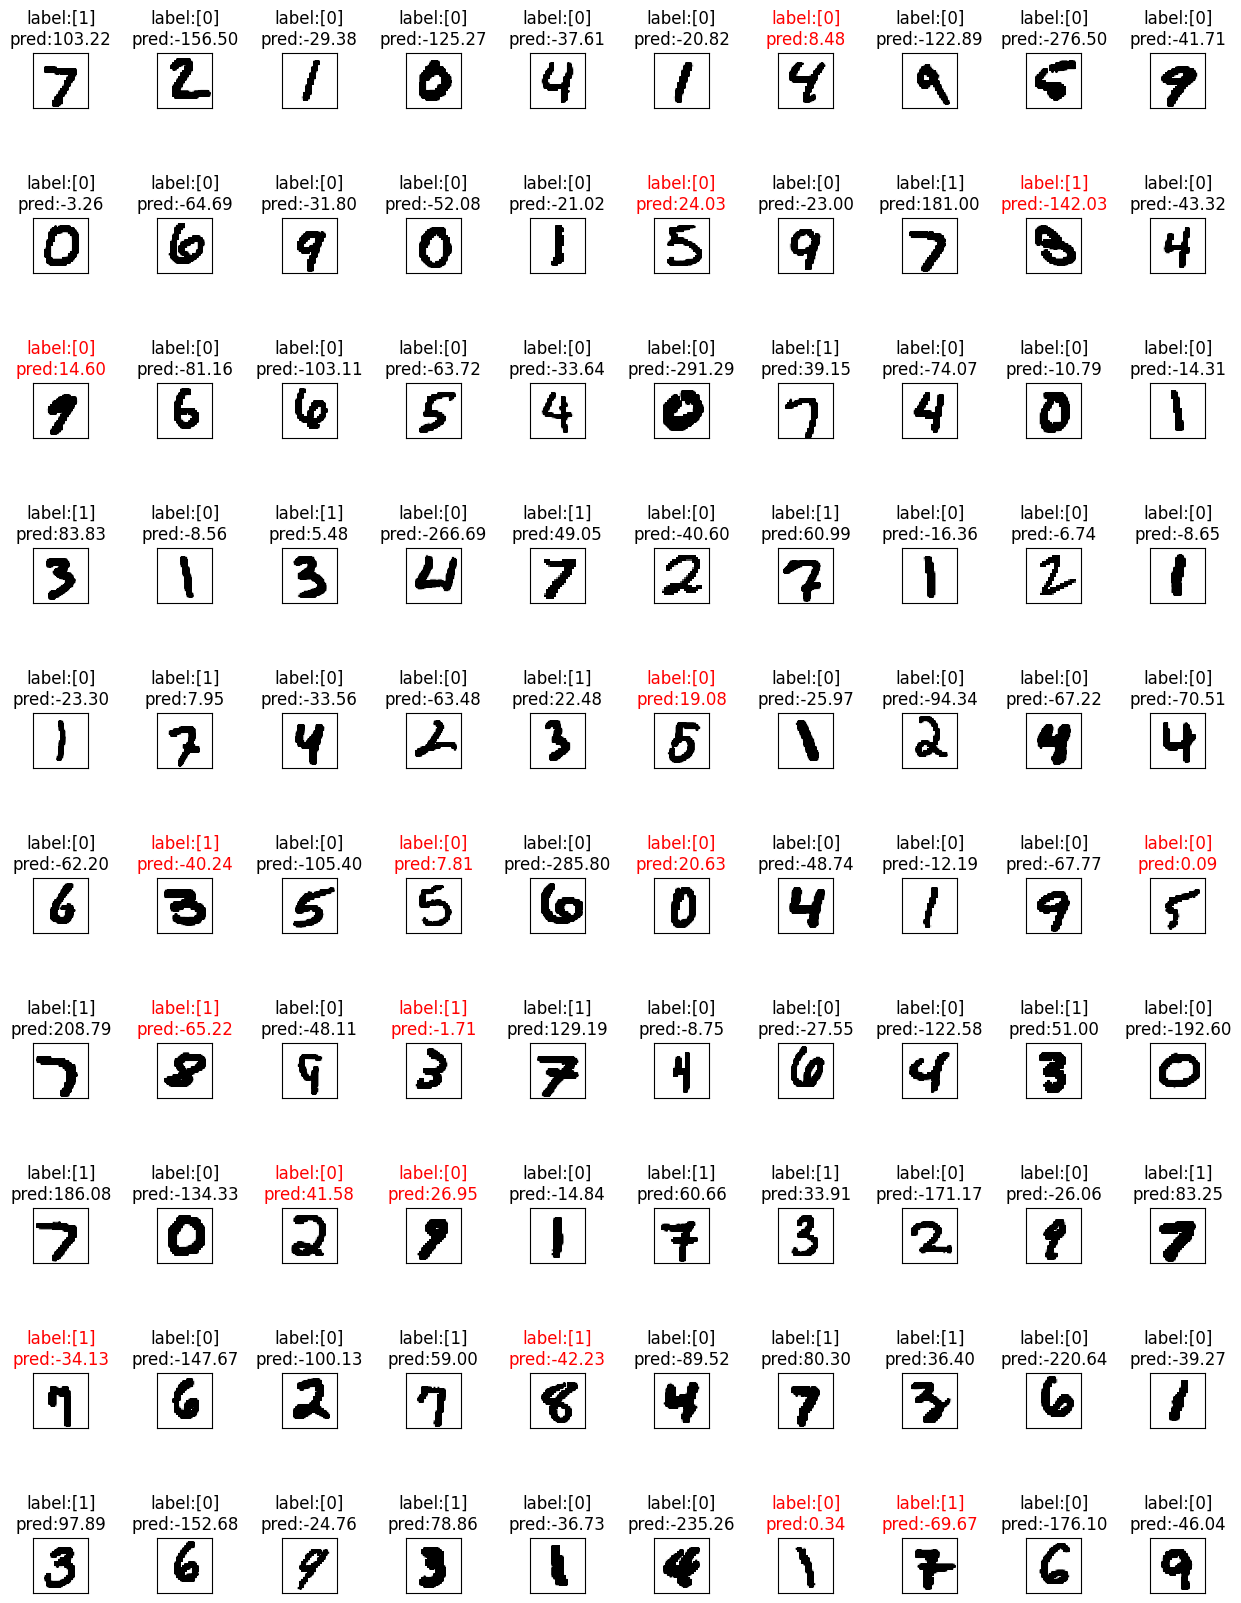

In [ ]:
plot_digits_with_predictions(model,mnist_testing_data,lucky_testing)

AUC: 0.9149892511617336
Precision [0.9159395  0.77912932]
Recall [0.9012593  0.80810093]
F1 [0.9085401  0.79335072]
Count [6988 3012]


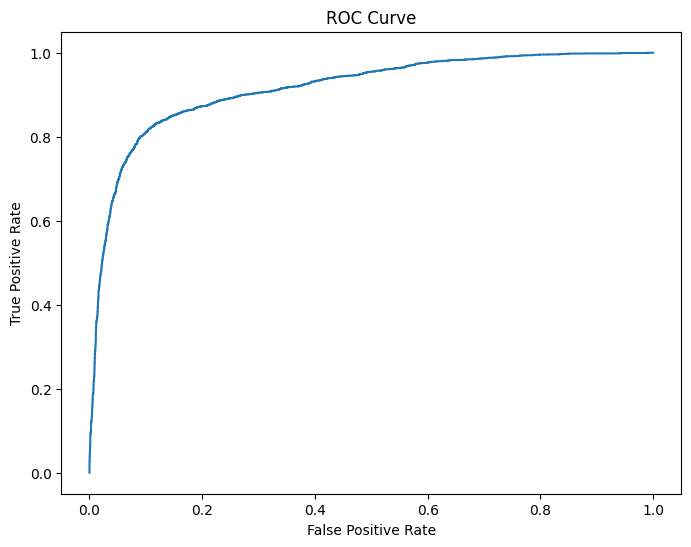

In [ ]:
preds = model(torch.tensor(mnist_testing_data).float()).detach().numpy()
fpr, tpr, thresholds = metrics.roc_curve(lucky_testing,preds)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("AUC:",metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p,r,f,count = metrics.precision_recall_fscore_support(lucky_testing,preds>0)
print("Precision",p)
print("Recall",r)
print("F1",f)
print("Count",count)

# Question 2

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:
X = mnist_data['data']
y = mnist_data['target']

In [ ]:
lucky_nums = ['3','7','8']
y_lucky = y.isin(lucky_nums).astype(int)

In [ ]:
scaler = StandardScaler()
x_norm = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_norm, y_lucky, test_size=0.33)

In [ ]:
k = 5
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
acc = accuracy_score(y_test, y_pred)
acc

0.9703896103896104

AUC: 0.9616343629382287
Precision [0.97355606 0.96291988]
Recall [0.98411116 0.93915757]
F1 [0.97880516 0.95089029]
Count [16049  7051]


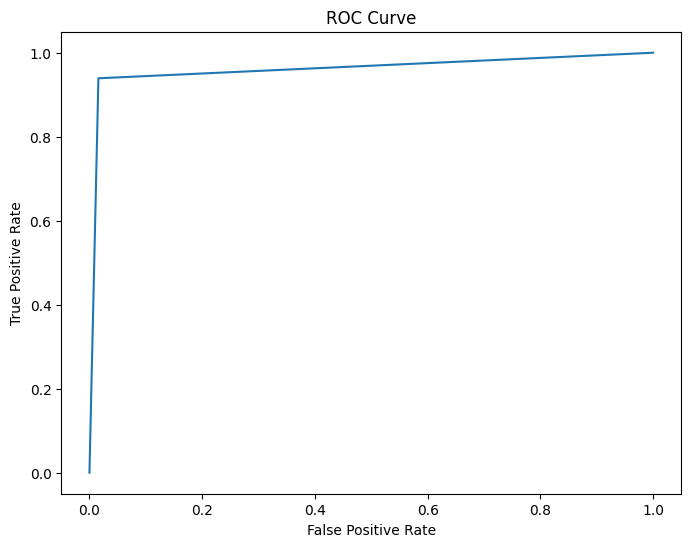

In [ ]:
preds = y_pred
fpr, tpr, thresholds = metrics.roc_curve(y_test,preds)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("AUC:",metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p,r,f,count = metrics.precision_recall_fscore_support(y_test,preds>0)
print("Precision",p)
print("Recall",r)
print("F1",f)
print("Count",count)

## Question 3

In [ ]:
def computeLabelAccuracy_nn(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      true_labels = target.data.max(1, keepdim=True)[1]
      correct += pred.eq(true_labels.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
def plot_digits_with_mnist_predictions(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).max(1, keepdim=True)[1].item()
          true_label = np.argmax(labels[i])
          drawColor = 'black'
          if pred_label != true_label:
            drawColor = 'red'
          axi.set_title("label:{}\npred:{}".format(true_label,pred_label), color=drawColor)
        im.set_clim(0, 16)

In [ ]:
class Classifier_3Layers(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, 20)  #Multiple matrix "layers"
        self.linear2 = nn.Linear(20, 15)             #This is 784->20->15->10 ...
        self.linear3 = nn.Linear(15, numClasses)     #... try different options

    def forward(self, x):
        x = x.view(-1,self.flatSize)   #Pytorch will replace -1 with the batch size
        x = torch.abs(self.linear1(x)) # "abs" and/or "relu" are example of non-linear tranformations
        x = F.relu(self.linear2(x))    # 'relu' keeps positive numbers same, sets negative numbers to 0
        x = self.linear3(x)
        return x

In [ ]:
mnist_training_data = mnist_data.data.values[0:60000,:]
mnist_training_labels = mnist_data.target.values[0:60000]
mnist_testing_data = mnist_data.data.values[60000:,:]
mnist_testing_labels = mnist_data.target.values[60000:]

In [ ]:
mnist_training_labels.to_numpy()

array(['5', '0', '4', ..., '5', '6', '8'], dtype=object)

In [ ]:
mnist_training_labels.to_numpy().astype(int)

array([5, 0, 4, ..., 5, 6, 8])

In [ ]:
torch.Tensor(mnist_training_labels.to_numpy().astype(int))

tensor([5., 0., 4.,  ..., 5., 6., 8.])

In [ ]:
torch.Tensor(mnist_training_labels.to_numpy().astype(int)).long()

tensor([5, 0, 4,  ..., 5, 6, 8])

In [ ]:
mnist_training_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_training_labels.to_numpy().astype(int))).long()).numpy()
mnist_testing_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_testing_labels.to_numpy().astype(int))).long()).numpy()

In [ ]:
training_dataset = NumpyDataset(mnist_training_data,mnist_training_labels_catigories)
testing_dataset = NumpyDataset(mnist_testing_data,mnist_testing_labels_catigories)

Loaded Data
Epoch [1/30], Train Loss: 0.8824, Test Loss: 0.3977
Epoch [6/30], Train Loss: 0.1545, Test Loss: 0.1875
Epoch [11/30], Train Loss: 0.1144, Test Loss: 0.1865
Epoch [16/30], Train Loss: 0.0963, Test Loss: 0.1639
Epoch [21/30], Train Loss: 0.0878, Test Loss: 0.1638
Epoch [26/30], Train Loss: 0.0777, Test Loss: 0.1800


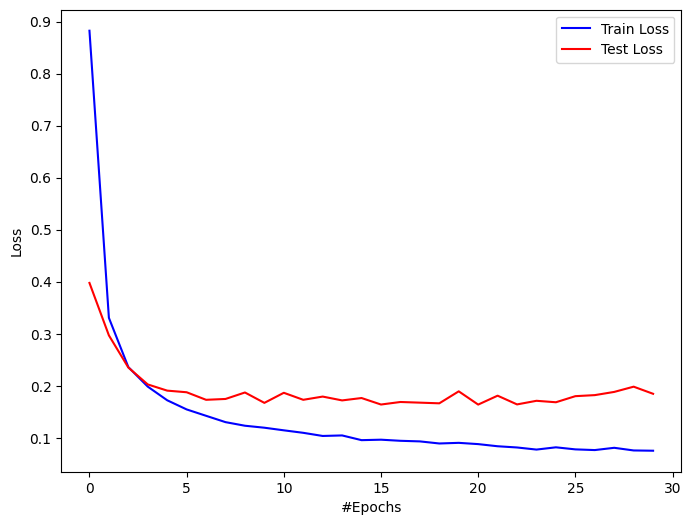

In [ ]:
#Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.001
batch_size = 200

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = Classifier_3Layers(image_w, image_h, 10)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = nn.CrossEntropyLoss() #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
computeLabelAccuracy_nn(model, training_generator, "Test Set")
computeLabelAccuracy_nn(model, testing_generator, "Train Set")


Test Set: Accuracy: 58735/60000 (97.9%)

Train Set: Accuracy: 9553/10000 (95.5%)


Text(70.72222222222221, 0.5, 'Predicted Class')

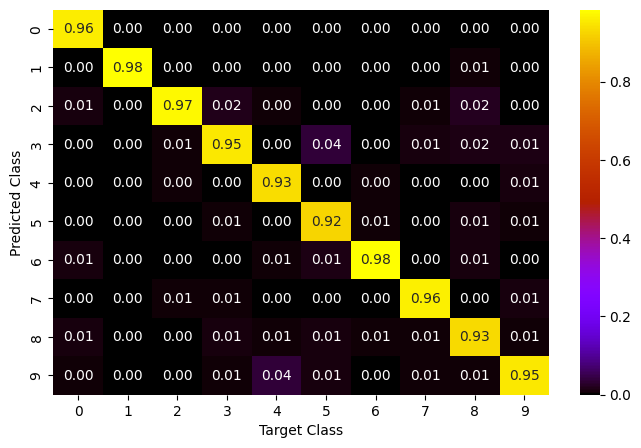

In [ ]:
data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=10000)
data_enumerator = enumerate(data_generator)
_, (images,labels) = next(data_enumerator)
with torch.no_grad():
    pred_catigories = model(images) #all 10 values
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
    true_labels = labels.data.max(1, keepdim=True)[1]
conf_mat = confusion_matrix(true_labels.numpy(), pred_labels.numpy(), normalize = "pred")
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt="0.2f", cmap = "gnuplot") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
plt.xlabel("Target Class")
plt.ylabel("Predicted Class")

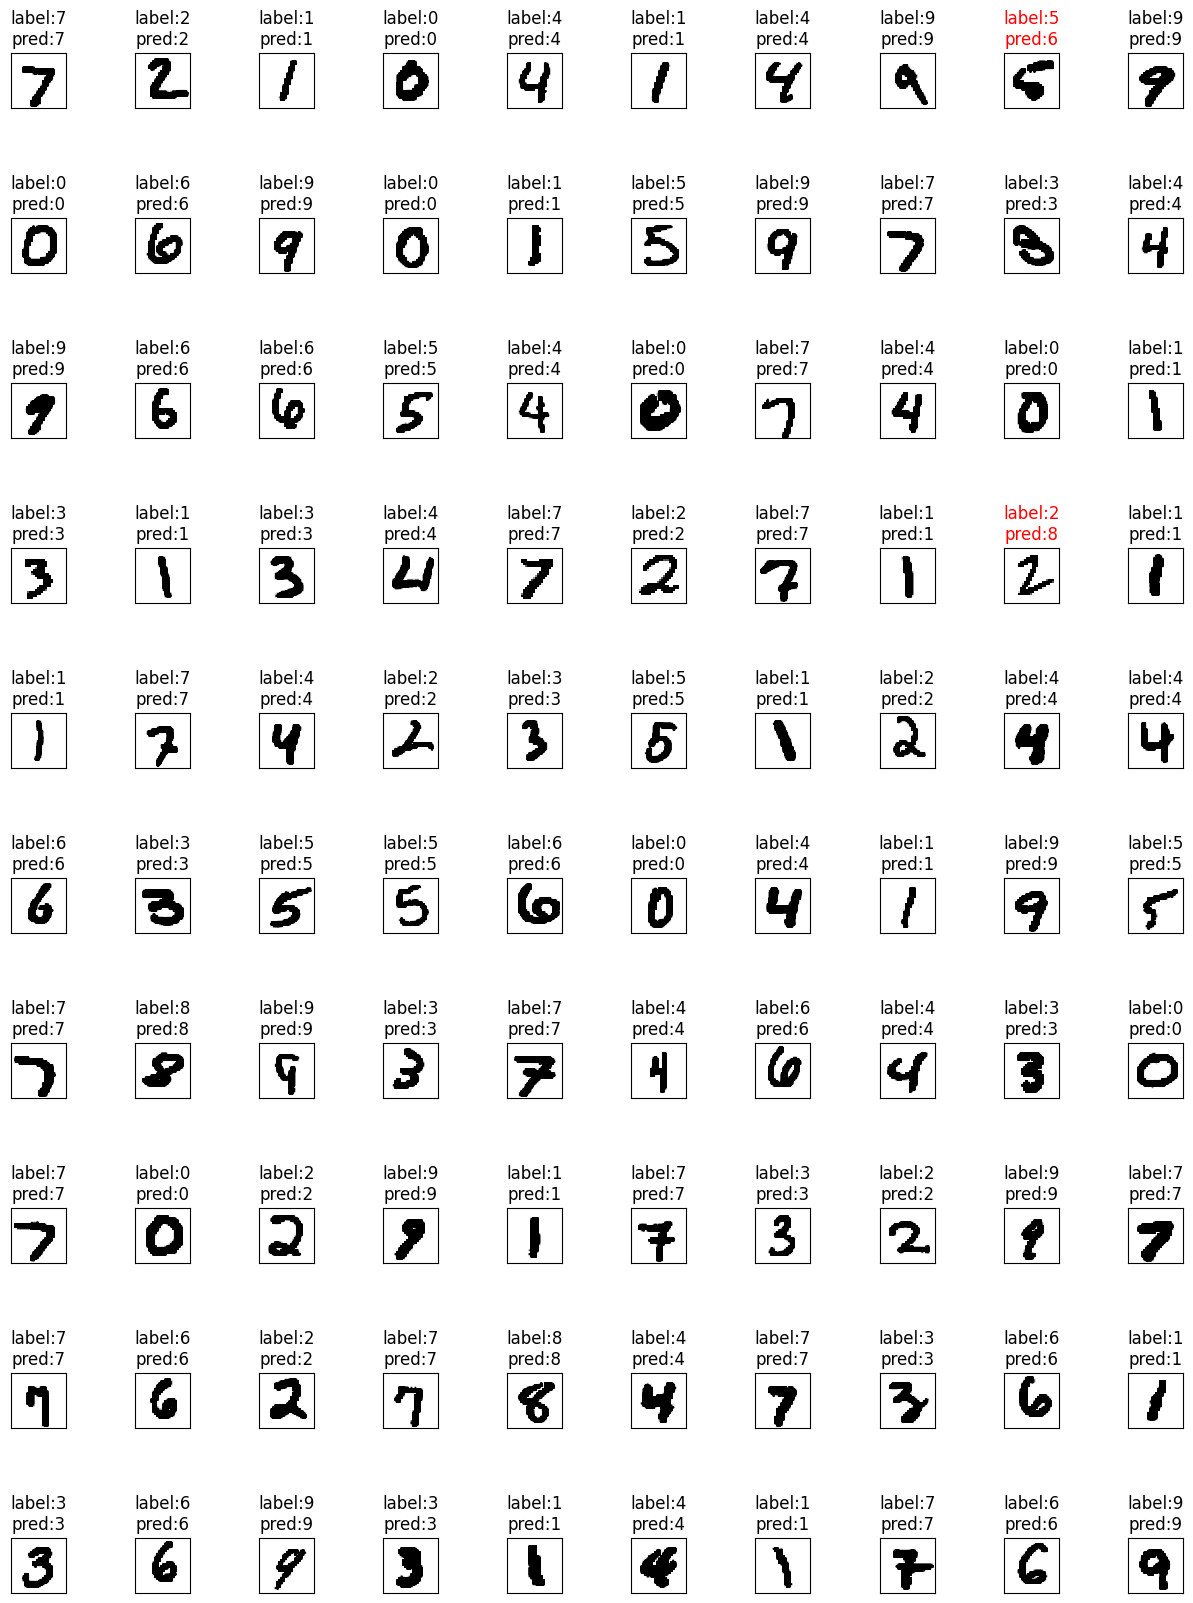

In [ ]:
plot_digits_with_mnist_predictions(model, mnist_testing_data, mnist_testing_labels_catigories)

In [ ]:
max_confidence = {digit: 0 for digit in range(10)}  # Store max confidence for each digit
most_confident_images = {digit: None for digit in range(10)}  # Store most confident images for each digit

with torch.no_grad():
    for images, labels in testing_generator:
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        confidences, predictions = torch.max(probabilities, 1)

        for i in range(images.shape[0]):
            digit = predictions[i].item()
            if confidences[i] > max_confidence[digit]:
                max_confidence[digit] = confidences[i]
                most_confident_images[digit] = images[i]

In [ ]:
most_confident_images

{0: tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   3.,  80., 195.,  85.,  80.,  80.,  80.,
          14.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.

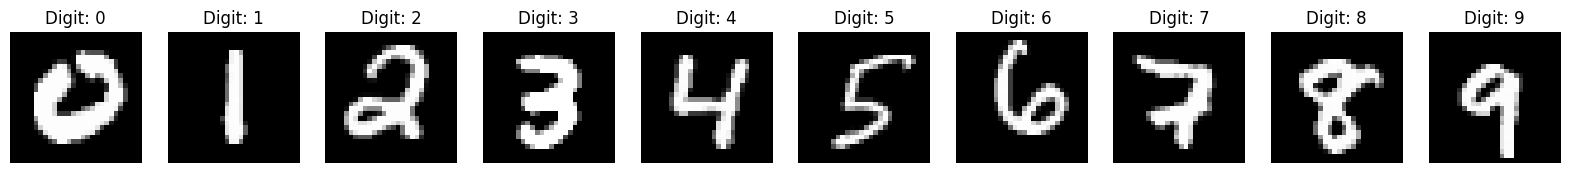

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for digit, ax in enumerate(axes):
    ax.imshow(most_confident_images[digit].reshape(28, 28), cmap='gray')
    ax.set_title(f"Digit: {digit}")
    ax.axis('off')
plt.show()
#the images show below are the images stored in most_confident_images